**Name:** LI XINYAN

**EID:** 55670594

# CS5489 - Tutorial 8
## Face Detection with MLPs

In this tutorial you will train an MLP to detect whether there is a face in a small image patch.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(100)
import skimage.io
import skimage.color
import skimage.transform
from scipy import ndimage

Next we will load keras and tensorflow.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import struct
K.set_image_data_format('channels_last')

In [3]:
print(keras.__version__, tf.__version__)

2.2.4-tf 1.15.0


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and place it in the same directory as this ipynb file.  **Do not unzip it.** Then run the following cell to load the images.

In [4]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 1
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = 'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):
        
        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")  

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1
            
        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(img)
            myfile.close()
            
            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)

        
zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

6977
944


Next we will convert the list of images into a block (array) of images for easier processing.

In [5]:
# convert list to numpy array
trainY = asarray(classes['train'])
testY  = asarray(classes['test'])

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)
testYb  = keras.utils.to_categorical(testY)

# convert list of ndarray to ndarray
trainI = asarray(imgdata['train']).reshape((6977,19,19,1))
testI  = asarray(imgdata['test']).reshape((944,19,19,1))

# cleanup memory
# del imgdata

# shuffle the data (since it is in order by class)
random.seed(123)
inds1 = random.permutation(len(trainI)).tolist()
inds2 = random.permutation(len(testI)).tolist()
trainYb = trainYb[inds1]
testYb  = testYb[inds2]
trainY = trainY[inds1]
testY  = testY[inds2]
trainI = trainI[inds1]
testI = testI[inds2]

print(trainI.shape)
print(testI.shape)

(6977, 19, 19, 1)
(944, 19, 19, 1)


Each image is a 19x19x1 array of pixel values.  The last dimension is the number of channels in the image - in this case the image is grayscale, so there is only 1 channel.  Run the below code to show an example:

(19, 19)


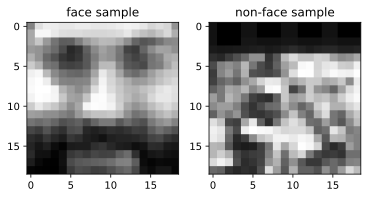

In [6]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(squeeze(trainI[1]), cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(squeeze(trainI[2]), cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

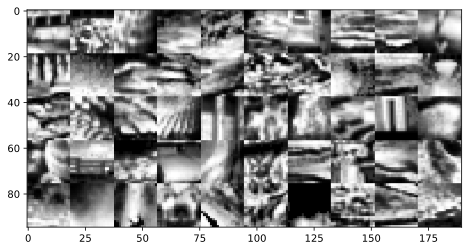

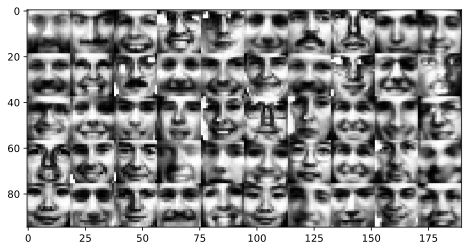

In [7]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(squeeze(X[i]))
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

# show images in a plot
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    # nc is the number of columns
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                if isinstance(titles, str):
                    plt.title(titles.format(idx))
                else:
                    plt.title(titles[idx])
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()

# show a few images
plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,0]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

plt.figure(figsize=(9,4))
plt.imshow(image_montage(trainI[trainYb[:,1]==1][0:50]), cmap='gray', interpolation='nearest')
plt.show()

Next we will generate the training/validation set from the training data.

In [8]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4488)

# make validation data
validsetI = (validI, validYb)

print(vtrainI.shape)
print(validI.shape)

(6279, 19, 19, 1)
(698, 19, 19, 1)


Here are some useful functions.

In [9]:
# compatible with v1 or v2
def tf_compat():
    if tf.__version__[0] == '1':
        return (tf.set_random_seed, 'acc')
    else:
        return (tf.random.set_seed, 'accuracy')
    
tf_set_seed, accname = tf_compat()

def plot_history(history): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    
    if accname in history.history:
        ax2 = ax1.twinx()

        ax2.plot(history.history[accname], 'b', label="training acc ({:.4f})".format(history.history[accname][-1]))
        ax2.plot(history.history['val_' + accname], 'b--', label="validation acc ({:.4f})".format(history.history['val_' + accname][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')
        



Now let's try a simple logistic regression classifier, trained using Keras. Since the inputs are images, we will convert the input image into a vector using the "Flatten" layer first.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 00013: early stopping
test accuracy: 0.5603813559322034


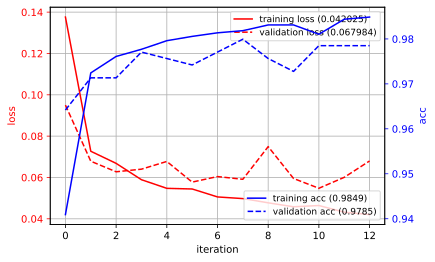

In [10]:
# initialize random seed
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,      # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.05, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI,  # specify the validation set
                 verbose=False)

plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

## 2. Detection using MLP

Train an MLP to classify an image patch as face or not face.  Use  `vtrainI` and `vtrainY` as the training set and `validsetI` as the validation set.  You can try different architectures, and adjust values of the learning rates, number of iterations, early stopping to get a good result.  Use a large batch size (e.g., 50) to speed up the training time.  Remember to add the `callbacks` so that you can monitor the training process.

Epoch 00027: early stopping
test accuracy: 0.7171610169491526


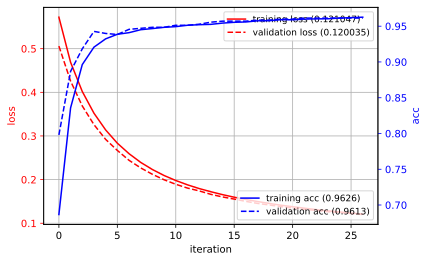

In [11]:
# Notice: input_dim are assigned for all layers

# Network: a 3-layer-MLP, 512->256->2
# momentum=0, acc=0.72
# momentum=0.5, acc=0.71
# momentum=0.9, acc=0.64

# Network: a 4-layer-MLP, 512->256->64->2
# momentum=0, acc=0.71
# momentum=0.5, acc=0.70
# momentum=0.9, acc=0.64

# Summary: use momentum=0. Meanwhile, 3 layers are engough

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, input_dim=361, activation='relu')) # hidden layer 2
# nn.add(Dense(units=64, input_dim=361, activation='relu')) # hidden layer 3
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)
predY = nn.predict_classes(testI, verbose=False) 
acc = metrics.accuracy_score(testY, predY) 
print("test accuracy:", acc)


Epoch 00027: early stopping
test accuracy: 0.7171610169491526


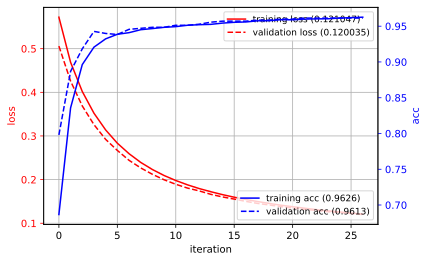

In [12]:
# Notice: input_dim are not assigned for all layers (use default)

# Network: a 3-layer-MLP, 512->256->2
# momentum=0, acc=0.72
# momentum=0.5, acc=0.71
# momentum=0.9, acc=0.64

# Network: a 4-layer-MLP, 512->256->64->2
# momentum=0, acc=0.71
# momentum=0.5, acc=0.70
# momentum=0.9, acc=0.60

# Summary: use momentum=0. Meanwhile, 3 layers are engough

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
# nn.add(Dense(units=64, activation='relu')) # hidden layer 3
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=64,
                 callbacks=callbacks_list,validation_data=validsetI, verbose=False)


plot_history(history)
predY = nn.predict_classes(testI, verbose=False) 
acc = metrics.accuracy_score(testY, predY) 
print("test accuracy:", acc)


In [17]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),  
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)        
    fs = prod(tmpimg.shape)
    
    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)
            
            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)
    
            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)
               
            if (doplot):             
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x
    
    return X

In [18]:
# Move the best solution (Random Forest) in Tutorial4 here and compare it with MLP

import numpy as np
from scipy import signal
from scipy import stats

trainXf = extract_features(imgdata['train'])
testXf = extract_features(imgdata['test'])

# first scale the features
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

paramsampler = {'n_estimators':      np.array([50, 100]),
                'max_depth':         np.array([20]),
                'min_samples_split': stats.uniform(0,0.5),
                'min_samples_leaf':  stats.uniform(0,0.5)}

rfrcv = model_selection.RandomizedSearchCV(
    ensemble.RandomForestClassifier(random_state=0, class_weight='balanced'),
    param_distributions=paramsampler, random_state=0,
    n_iter = 200, cv = 3, verbose = 1, n_jobs = -1)

rfrcv.fit(trainXfn, trainY)
print("best params:", rfrcv.best_params_)

predY_rf = rfrcv.best_estimator_.predict(testXfn)
acc = metrics.accuracy_score(testY, predY_rf)
print("Random Forest Classifier Test accuracy =", acc)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
best params: {'max_depth': 20, 'min_samples_leaf': 0.019593896127160337, 'min_samples_split': 0.1414034812882048, 'n_estimators': 50}
Random Forest Classifier Test accuracy = 0.4936440677966102


In [19]:
# Move the best linear solution (SVC) in Tutorial4 here and compare it with MLP

svmlinear = svm.SVC(kernel='linear')
svmlinear.fit(trainXfn, trainY)

predY_svm = svmlinear.predict(testXfn)
acc = metrics.accuracy_score(testY, predY_svm)
print("Test accuracy =", acc)

Test accuracy = 0.5


### How does the MLP compare to the linear and non-linear classifiers that you tried in Tutorial 4?

- In tutorial4, the best linear model is SVM. I used the same codes here and it got 0.52 accuracy (not much better than random guessing).

- In tutorial4, the best non-linear model is a random forest classifier that achieves 0.81 accuracy on the test set. I used the same codes here but only got 0.5 accuracy (not much better than random guessing).

- The linear SVM model has very low training speed in this task while the random forest classifier is trained as far as the MLP.

- MLP performs better. It has higher accuracy, faster training speed, and handle the larger dataset well.

## 3. Data Augmentation

The reason why we are not getting good accuracy with MLP is because there is not a lot of data, only ~7000 training images, compared to the number of parameters in the MLP.

Augmenting the training data with permutations  (e.g., scaling, rotating, skewing, flipping) is a good way to create more "data" for training the network.
This can prevent the MLP from overfitting, and improve its generalization.  We will use the built-in `ImageDataGenerator` to apply geometric transformations.

We can also add per-pixel noise or transformations. We define a few functions for adding per-pixel noise.  The following functions will add Gaussian pixel noise, add corruption noise (setting some input pixels to 0), scale and shift pixel values (changing contrast and brightness).

In [20]:
def add_gauss_noise(X, sigma2=0.05):
    # add Gaussian noise with zero mean, and variance sigma2
    return X + random.normal(0, sigma2, X.shape)

def add_corrupt_noise(X, p=0.1):
    # apply pixel corruption (zero out value) with probability p
    return X * random.binomial(1, 1-p, X.shape)

def add_scale_shift(X, sigma2=0.1, alpha2=0.2):
    # randomly scale and shift the pixel values (same for each image)
    # Xnew = a X + b
    # a is sampled from a Gaussian with mean 1, and variance sigma2
    # b is sampled from a Gaussian with mean 0, and variance alpha2
    if X.ndim == 3:
        dshape = (X.shape[0],1,1)
    elif X.ndim == 4:
        dshape = (X.shape[0],1,1,1)
    else:
        dshape = (1,)
    a = random.normal(1,sigma2, dshape)
    b = random.normal(0,alpha2, dshape)
    return minimum(maximum( a*X + b, 0.0), 1.0)

Next, we define a function for adding per-pixel noise (in this case just Gaussian noise). The noise is included using the `preprocessing_function` input of the `ImageDataGenerator`.

In [21]:
# build the noise function
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

Next we can show some examples of augmented images. Run the code below to see different random augmentations.

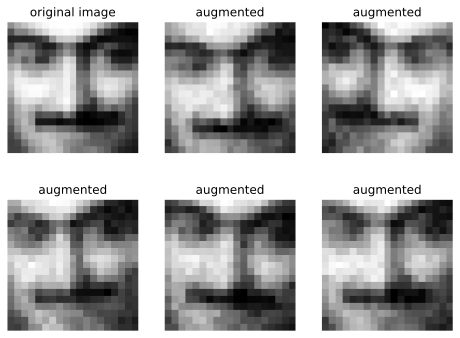

In [22]:
img = trainI[4]
imgs = [img[:,:,0]]

cnt = 0
for augimg, augy in datagen.flow(img.reshape(1,19,19,1), [1], batch_size=1):
    imgs.append(augimg[0,:,:,0])
    cnt += 1
    if cnt > 4:
        # we need to break the loop by hand because
        # the generator loops indefinitely
        break

titles = ['original image', 'augmented', 'augmented', 'augmented', 'augmented', 'augmented']
plt.figure(figsize=(8,6))
show_imgs(imgs, nc=3, titles=titles)

The augmented images look similar to the original image, but contain small differences that the network can use to learn more about the class.

Now let's try training logistic regression with data augmentation. Instead of `fit`, we now  use the `fit_generator` method, which will pass each input through the ImageDataGenerator before sending it to the MLP.  We disable early stopping so that the network sees more noisy data.

In [23]:
# addNoise 1: 0.04
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# data augmenter 1
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [24]:
# initialize random seed
K.clear_session()
random.seed(4487); tf_set_seed(4487)

# build the network for logistic regression
nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=2, activation='softmax'))  # classification layer (2 classes)

# early stopping criteria
earlystop = keras.callbacks.EarlyStopping(
               monitor='val_'+accname,             # use validation accuracy for stopping
               min_delta=0.0001, patience=5, 
               verbose=1, mode='auto')
callbacks_list = [earlystop]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True), 
           metrics=['accuracy']  # also calculate accuracy during training
          )

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=50),  # data from generator
            steps_per_epoch=len(vtrainI)/50,    # should be number of batches per epoch
            epochs=50,
            #callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)


Epoch 1/50
126/125 [==============================] - 2s 14ms/step - loss: 0.2681 - acc: 0.8944 - val_loss: 0.1636 - val_acc: 0.9327
Epoch 2/50
126/125 [==============================] - 2s 18ms/step - loss: 0.2058 - acc: 0.9154 - val_loss: 0.1402 - val_acc: 0.9370
Epoch 3/50
126/125 [==============================] - 2s 15ms/step - loss: 0.1848 - acc: 0.9258 - val_loss: 0.1247 - val_acc: 0.9456
Epoch 4/50
126/125 [==============================] - 2s 17ms/step - loss: 0.1800 - acc: 0.9283 - val_loss: 0.1198 - val_acc: 0.9513
Epoch 5/50
126/125 [==============================] - 2s 15ms/step - loss: 0.1690 - acc: 0.9345 - val_loss: 0.1266 - val_acc: 0.9470
Epoch 6/50
126/125 [==============================] - 2s 17ms/step - loss: 0.1671 - acc: 0.9330 - val_loss: 0.1166 - val_acc: 0.9513
Epoch 7/50
126/125 [==============================] - 1s 12ms/step - loss: 0.1700 - acc: 0.9310 - val_loss: 0.1343 - val_acc: 0.9427
Epoch 8/50
126/125 [==============================] - 2s 13ms/step - 

126/125 [==============================] - 2s 13ms/step - loss: 0.1543 - acc: 0.9374 - val_loss: 0.1261 - val_acc: 0.9413
Epoch 20/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1519 - acc: 0.9400 - val_loss: 0.1352 - val_acc: 0.9384
Epoch 21/50
126/125 [==============================] - 2s 19ms/step - loss: 0.1580 - acc: 0.9380 - val_loss: 0.1446 - val_acc: 0.9312
Epoch 22/50
126/125 [==============================] - 2s 17ms/step - loss: 0.1542 - acc: 0.9371 - val_loss: 0.1028 - val_acc: 0.9570
Epoch 23/50
126/125 [==============================] - 2s 17ms/step - loss: 0.1531 - acc: 0.9395 - val_loss: 0.1060 - val_acc: 0.9556
Epoch 24/50
126/125 [==============================] - 2s 18ms/step - loss: 0.1565 - acc: 0.9363 - val_loss: 0.1040 - val_acc: 0.9585
Epoch 25/50
126/125 [==============================] - 3s 21ms/step - loss: 0.1580 - acc: 0.9341 - val_loss: 0.1423 - val_acc: 0.9384
Epoch 26/50
126/125 [==============================] - 3s 22ms/step - loss

126/125 [==============================] - 3s 23ms/step - loss: 0.1486 - acc: 0.9400 - val_loss: 0.1098 - val_acc: 0.9527
Epoch 38/50
126/125 [==============================] - 2s 18ms/step - loss: 0.1532 - acc: 0.9388 - val_loss: 0.1006 - val_acc: 0.9556
Epoch 39/50
126/125 [==============================] - 2s 17ms/step - loss: 0.1501 - acc: 0.9423 - val_loss: 0.0890 - val_acc: 0.9656
Epoch 40/50
126/125 [==============================] - 2s 12ms/step - loss: 0.1529 - acc: 0.9409 - val_loss: 0.0967 - val_acc: 0.9628
Epoch 41/50
126/125 [==============================] - 2s 12ms/step - loss: 0.1527 - acc: 0.9373 - val_loss: 0.1052 - val_acc: 0.9585
Epoch 42/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1495 - acc: 0.9387 - val_loss: 0.1218 - val_acc: 0.9441
Epoch 43/50
126/125 [==============================] - 2s 14ms/step - loss: 0.1531 - acc: 0.9393 - val_loss: 0.0937 - val_acc: 0.9642
Epoch 44/50
126/125 [==============================] - 2s 14ms/step - loss

test accuracy: 0.6811440677966102


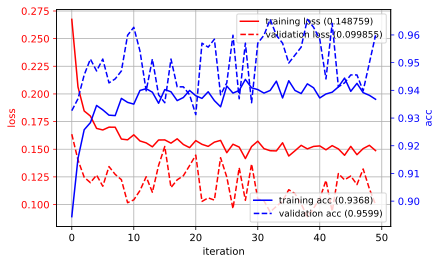

In [25]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

Using data augmentation, the test accuracy improves from 0.622 to 0.697!

Now train your best MLP from the previous section using data augmentation. 
Try different per-pixel noise levels, and different options of the ImageDataGenerator (see [here](https://keras.io/preprocessing/image/)), 
and combinations of them.  Hopefully you should be able to improve the accuracy! 

### addNoise 1: 0.04 ~ add_gauss_noise

In [26]:
# addNoise 1: 0.04
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# data augmenter 1
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [27]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 3s 28ms/step - loss: 0.5996 - acc: 0.6589 - val_loss: 0.5253 - val_acc: 0.7779
Epoch 2/100
99/98 [==============================] - 2s 20ms/step - loss: 0.5206 - acc: 0.7557 - val_loss: 0.4545 - val_acc: 0.8983
Epoch 3/100
99/98 [==============================] - 2s 17ms/step - loss: 0.4660 - acc: 0.8315 - val_loss: 0.4026 - val_acc: 0.9312
Epoch 4/100
99/98 [==============================] - 2s 16ms/step - loss: 0.4258 - acc: 0.8664 - val_loss: 0.3591 - val_acc: 0.9355
Epoch 5/100
99/98 [==============================] - 2s 23ms/step - loss: 0.3927 - acc: 0.8758 - val_loss: 0.3261 - val_acc: 0.9341
Epoch 6/100
99/98 [==============================] - 2s 16ms/step - loss: 0.3630 - acc: 0.8915 - val_loss: 0.2977 - val_acc: 0.9327
Epoch 7/100
99/98 [==============================] - 2s 17ms/step - loss: 0.3375 - acc: 0.8984 - val_loss: 0.2766 - val_acc: 0.9312
Epoch 8/100
99/98 [==============================] - 2s 18ms/step - loss: 0.

test accuracy: 0.7690677966101694


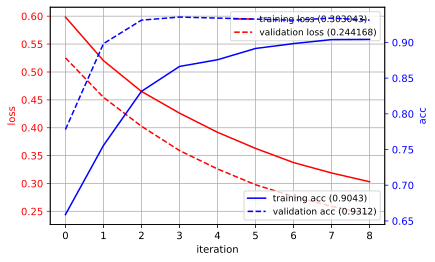

In [28]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### addNoise 2: 0.08 ~ add_gauss_noise

In [29]:
# addNoise 2: 0.08
def addNoise(X):
    return add_gauss_noise(X, 0.04)

# data augmenter 1
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [30]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 2s 20ms/step - loss: 0.5995 - acc: 0.6619 - val_loss: 0.5251 - val_acc: 0.7665
Epoch 2/100
99/98 [==============================] - 2s 17ms/step - loss: 0.5204 - acc: 0.7504 - val_loss: 0.4530 - val_acc: 0.8797
Epoch 3/100
99/98 [==============================] - 2s 22ms/step - loss: 0.4668 - acc: 0.8274 - val_loss: 0.4012 - val_acc: 0.9241
Epoch 4/100
99/98 [==============================] - 2s 20ms/step - loss: 0.4252 - acc: 0.8689 - val_loss: 0.3569 - val_acc: 0.9269
Epoch 5/100
99/98 [==============================] - 2s 18ms/step - loss: 0.3898 - acc: 0.8825 - val_loss: 0.3264 - val_acc: 0.9327
Epoch 6/100
99/98 [==============================] - 2s 17ms/step - loss: 0.3626 - acc: 0.8946 - val_loss: 0.2967 - val_acc: 0.9327
Epoch 7/100
99/98 [==============================] - 2s 17ms/step - loss: 0.3393 - acc: 0.8946 - val_loss: 0.2774 - val_acc: 0.9327
Epoch 8/100
99/98 [==============================] - 2s 19ms/step - loss: 0.

test accuracy: 0.7754237288135594


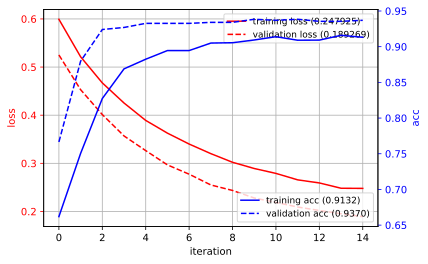

In [31]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### addNoise 3: 0.10 ~ add_gauss_noise

In [32]:
# addNoise 2: 0.1
def addNoise(X):
    return add_gauss_noise(X, 0.1)

# data augmenter 1
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [33]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 2s 23ms/step - loss: 0.6049 - acc: 0.6633 - val_loss: 0.5291 - val_acc: 0.8023
Epoch 2/100
99/98 [==============================] - 2s 18ms/step - loss: 0.5248 - acc: 0.7484 - val_loss: 0.4572 - val_acc: 0.8997
Epoch 3/100
99/98 [==============================] - 2s 18ms/step - loss: 0.4743 - acc: 0.8231 - val_loss: 0.4052 - val_acc: 0.9284
Epoch 4/100
99/98 [==============================] - 3s 26ms/step - loss: 0.4320 - acc: 0.8600 - val_loss: 0.3600 - val_acc: 0.9298
Epoch 5/100
99/98 [==============================] - 2s 20ms/step - loss: 0.4005 - acc: 0.8659 - val_loss: 0.3316 - val_acc: 0.9284
Epoch 6/100
99/98 [==============================] - 2s 18ms/step - loss: 0.3703 - acc: 0.8847 - val_loss: 0.2984 - val_acc: 0.9327
Epoch 7/100
99/98 [==============================] - 2s 18ms/step - loss: 0.3485 - acc: 0.8896 - val_loss: 0.2777 - val_acc: 0.9327
Epoch 8/100
99/98 [==============================] - 2s 25ms/step - loss: 0.

test accuracy: 0.777542372881356


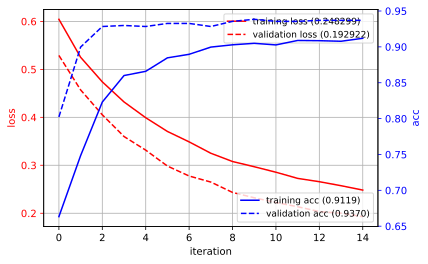

In [34]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### addNoise 4: 0.15 ~ add_gauss_noise

In [35]:
# addNoise 2: 0.15
def addNoise(X):
    return add_gauss_noise(X, 0.15)

# data augmenter 1
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [36]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 3s 31ms/step - loss: 0.6109 - acc: 0.6638 - val_loss: 0.5330 - val_acc: 0.8123
Epoch 2/100
99/98 [==============================] - 2s 20ms/step - loss: 0.5310 - acc: 0.7508 - val_loss: 0.4581 - val_acc: 0.8768
Epoch 3/100
99/98 [==============================] - 2s 20ms/step - loss: 0.4805 - acc: 0.8097 - val_loss: 0.4086 - val_acc: 0.9298
Epoch 4/100
99/98 [==============================] - 3s 26ms/step - loss: 0.4390 - acc: 0.8551 - val_loss: 0.3639 - val_acc: 0.9312
Epoch 5/100
99/98 [==============================] - 2s 24ms/step - loss: 0.4065 - acc: 0.8686 - val_loss: 0.3296 - val_acc: 0.9327
Epoch 6/100
99/98 [==============================] - 2s 22ms/step - loss: 0.3767 - acc: 0.8826 - val_loss: 0.3022 - val_acc: 0.9312
Epoch 7/100
99/98 [==============================] - 2s 22ms/step - loss: 0.3531 - acc: 0.8874 - val_loss: 0.2819 - val_acc: 0.9284
Epoch 8/100
99/98 [==============================] - 3s 27ms/step - loss: 0.

99/98 [==============================] - 2s 22ms/step - loss: 0.2434 - acc: 0.9145 - val_loss: 0.1787 - val_acc: 0.9384
Epoch 18/100
99/98 [==============================] - 2s 23ms/step - loss: 0.2418 - acc: 0.9099 - val_loss: 0.1791 - val_acc: 0.9341
Epoch 19/100
99/98 [==============================] - 2s 20ms/step - loss: 0.2321 - acc: 0.9105 - val_loss: 0.1741 - val_acc: 0.9355
Epoch 20/100
99/98 [==============================] - 2s 19ms/step - loss: 0.2366 - acc: 0.9092 - val_loss: 0.1738 - val_acc: 0.9355
Epoch 21/100
99/98 [==============================] - 2s 21ms/step - loss: 0.2244 - acc: 0.9167 - val_loss: 0.1683 - val_acc: 0.9370
Epoch 00021: early stopping


test accuracy: 0.7807203389830508


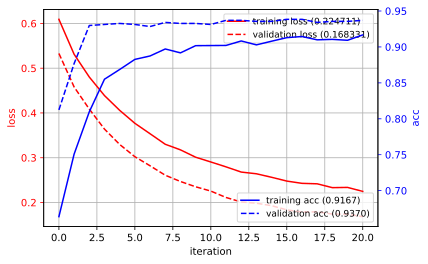

In [37]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### addNoise 5: 0.1 ~ add_corrupt_noise

In [38]:
# build the noise function
def addNoise(X):
    return add_corrupt_noise(X, p=0.1)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [39]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 2s 18ms/step - loss: 0.6188 - acc: 0.6562 - val_loss: 0.5395 - val_acc: 0.7163
Epoch 2/100
99/98 [==============================] - 2s 18ms/step - loss: 0.5558 - acc: 0.7028 - val_loss: 0.4704 - val_acc: 0.8625
Epoch 3/100
99/98 [==============================] - 2s 16ms/step - loss: 0.5132 - acc: 0.7802 - val_loss: 0.4194 - val_acc: 0.9140
Epoch 4/100
99/98 [==============================] - 2s 19ms/step - loss: 0.4712 - acc: 0.8251 - val_loss: 0.3753 - val_acc: 0.9226
Epoch 5/100
99/98 [==============================] - 2s 17ms/step - loss: 0.4425 - acc: 0.8431 - val_loss: 0.3405 - val_acc: 0.9298
Epoch 6/100
99/98 [==============================] - 2s 16ms/step - loss: 0.4123 - acc: 0.8640 - val_loss: 0.3153 - val_acc: 0.9298
Epoch 7/100
99/98 [==============================] - 2s 15ms/step - loss: 0.3854 - acc: 0.8782 - val_loss: 0.2883 - val_acc: 0.9298
Epoch 8/100
99/98 [==============================] - 2s 16ms/step - loss: 0.

99/98 [==============================] - 2s 16ms/step - loss: 0.2638 - acc: 0.9003 - val_loss: 0.1845 - val_acc: 0.9341
Epoch 18/100
99/98 [==============================] - 2s 16ms/step - loss: 0.2588 - acc: 0.9060 - val_loss: 0.1829 - val_acc: 0.9355
Epoch 00018: early stopping


test accuracy: 0.7828389830508474


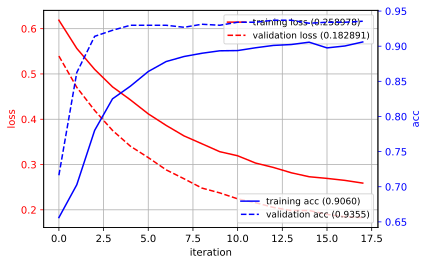

In [40]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### addNoise 6: 0.2 ~ add_corrupt_noise

In [41]:
# build the noise function
def addNoise(X):
    return add_corrupt_noise(X, p=0.1)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [42]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 2s 19ms/step - loss: 0.6206 - acc: 0.6571 - val_loss: 0.5407 - val_acc: 0.7135
Epoch 2/100
99/98 [==============================] - 3s 29ms/step - loss: 0.5579 - acc: 0.7028 - val_loss: 0.4716 - val_acc: 0.8367
Epoch 3/100
99/98 [==============================] - 2s 24ms/step - loss: 0.5118 - acc: 0.7737 - val_loss: 0.4192 - val_acc: 0.8997
Epoch 4/100
99/98 [==============================] - 2s 19ms/step - loss: 0.4707 - acc: 0.8210 - val_loss: 0.3776 - val_acc: 0.9284
Epoch 5/100
99/98 [==============================] - 2s 19ms/step - loss: 0.4394 - acc: 0.8533 - val_loss: 0.3403 - val_acc: 0.9312
Epoch 6/100
99/98 [==============================] - 2s 17ms/step - loss: 0.4125 - acc: 0.8635 - val_loss: 0.3132 - val_acc: 0.9327
Epoch 7/100
99/98 [==============================] - 2s 17ms/step - loss: 0.3861 - acc: 0.8748 - val_loss: 0.2886 - val_acc: 0.9298
Epoch 8/100
99/98 [==============================] - 2s 20ms/step - loss: 0.

99/98 [==============================] - 2s 21ms/step - loss: 0.2599 - acc: 0.9068 - val_loss: 0.1866 - val_acc: 0.9327
Epoch 00017: early stopping


test accuracy: 0.7817796610169492


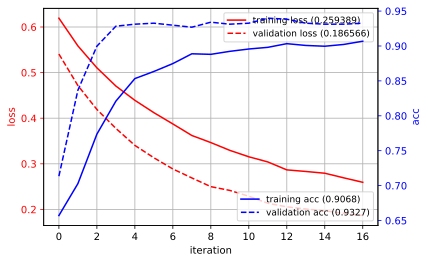

In [43]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

### addNoise 5: sigma2=0.1, alpha2=0.2 ~ add_scale_shift

In [44]:
# build the noise function
def addNoise(X):
    return add_scale_shift(X, sigma2=0.5, alpha2=0.5)

# build the data augmenter
datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_last')

In [45]:
# Use the best model above: a 3-layer-MLP, 512->256->2
# lr=0.001, epoch=100, batsize=64, momentum=0

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # input layer flatterning
nn.add(Dense(units=512, input_dim=361, activation='relu')) # hidden layer 1
nn.add(Dense(units=256, activation='relu')) # hidden layer 2
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100, callbacks=callbacks_list, 
            validation_data=validsetI, verbose=True)

Epoch 1/100
99/98 [==============================] - 3s 31ms/step - loss: 0.6428 - acc: 0.6482 - val_loss: 0.5830 - val_acc: 0.6662
Epoch 2/100
99/98 [==============================] - 2s 24ms/step - loss: 0.6214 - acc: 0.6589 - val_loss: 0.5380 - val_acc: 0.7393
Epoch 3/100
99/98 [==============================] - 2s 18ms/step - loss: 0.6063 - acc: 0.6734 - val_loss: 0.5019 - val_acc: 0.8524
Epoch 4/100
99/98 [==============================] - 2s 17ms/step - loss: 0.5901 - acc: 0.6875 - val_loss: 0.4750 - val_acc: 0.9040
Epoch 5/100
99/98 [==============================] - 2s 17ms/step - loss: 0.5845 - acc: 0.6941 - val_loss: 0.4513 - val_acc: 0.9298
Epoch 6/100
99/98 [==============================] - 2s 17ms/step - loss: 0.5721 - acc: 0.7039 - val_loss: 0.4346 - val_acc: 0.9284
Epoch 7/100
99/98 [==============================] - 2s 18ms/step - loss: 0.5663 - acc: 0.7121 - val_loss: 0.4177 - val_acc: 0.9226
Epoch 8/100
99/98 [==============================] - 2s 19ms/step - loss: 0.

test accuracy: 0.7934322033898306


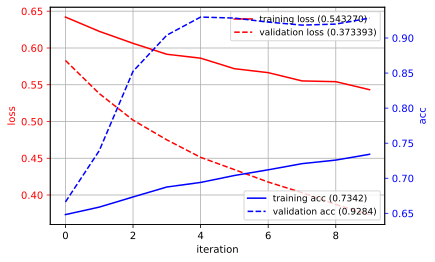

In [46]:
plot_history(history)
predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (6279, 19, 19, 1) (19 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 00016: early stopping
test accuracy: 0.7266949152542372


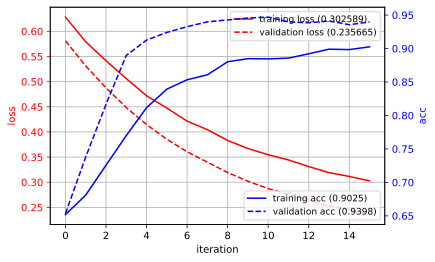

In [47]:
def addNoise(X):
    return add_scale_shift(X)

datagen = ImageDataGenerator(
    rotation_range=10,         # image rotation
    width_shift_range=0.05,     # image shifting
    height_shift_range=0.05,    # image shifting
    shear_range=0.05,           # shear transformation
    zoom_range=0.05,            # zooming
    horizontal_flip=True,       # horizontal flipping
    preprocessing_function=addNoise,  # add per-pixel noise
    data_format='channels_first')

K.clear_session()
random.seed(4487); tf.set_random_seed(4487)

nn = Sequential()
nn.add(Flatten(input_shape=(19,19,1)))        # vectorize the input image
nn.add(Dense(units=50, input_dim=361, activation='relu')) # hidden layer 
nn.add(Dense(units=2, activation='softmax')) # output layer

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy, 
           optimizer=keras.optimizers.SGD(lr=0.001, momentum=0, nesterov=True),
           metrics=['accuracy'])

# fit with data generator
history = nn.fit_generator(
            datagen.flow(vtrainI, vtrainYb, batch_size=64),  # data from generator
            steps_per_epoch=len(vtrainI)/64,    # should be number of batches per epoch
            epochs=100,
          callbacks=callbacks_list, 
            validation_data=validsetI, verbose=False)


plot_history(history)
predY = nn.predict_classes(testI, verbose=False) 
acc = metrics.accuracy_score(testY, predY) 
print("test accuracy:", acc)

### Which type of augmentation improves the accuracy the most?  Why?  How does NN with data augmentation compare with your work in Tutorial 4?

- I can get an accuracy around 0.78 under all 3 types of augmentation. So I think they do not have too much difference in respect to accuracy.

- However, the add_scale_shift() method encourages the classifier to converge (early stop is usually triggered in around 10 epoches).

- I also observe that the add_scale_shift() method can achieve slightly higher accuracy on the test set. But during the training process, it performs poor on train acc while achieves good valid acc.

- Compared with T4, we do better now.

# Test image
Now lets try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [48]:
fname = "nasa-small.png"

(210, 480)


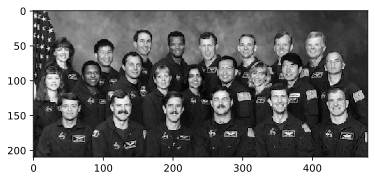

In [49]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
testimg = skimage.color.rgb2gray(testimg3)
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [50]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3], 1))
print(patches2.shape)

# histogram equalize patches (improves contrast)
newI = empty(patches2.shape)
for i in range(patches2.shape[0]):
    newI[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:],128)
#     newI[i,:,:] = skimage.exposure.rescale_intensity(patches2[i,:,:])
# newI = patches2


(5568, 19, 19, 1)


/opt/anaconda3/lib/python3.7/site-packages/skimage/exposure/exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Now predict using your classifier.  The extracted images are in `newI`.

In [51]:
### YOUR CODE HERE
prednewY = nn.predict_classes(newI)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

(-0.5, 479.5, 209.5, -0.5)

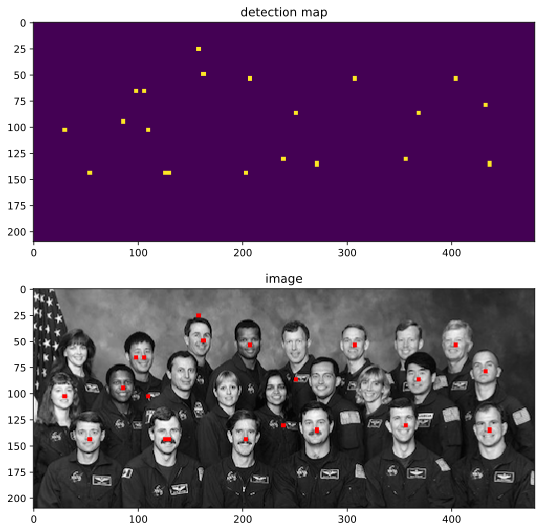

In [52]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
# show detections with image
# detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

### How did your face detector do compared to the last version?

- Much better. It can recognize more human faces and has higher true positive rate, lower false positive rate, and false negative rate (especially when apply the histogram equalization to improves contrast).

- All the people on the first front row are correctly recognized (red dots on nosetips). Meanwhile, it seems that the classifier make more errors for people in the back rows.

- The top right human faces are not recognized the same as in the last verion (which is wired).

- Below I tried on several group photos, the performance is quite satisfing.


You can try it on your own images.  The faces should all be around 19x19 pixels though.
We only used 1/8 of the training data. Try using more data to train it!

In [53]:
# fname1 = "mine_f.png"

# # load image
# testimg1 = skimage.io.imread(fname1)

# # convert to grayscale
# testimg2 = skimage.color.rgb2gray(testimg1)
# print(testimg2.shape)
# plt.imshow(testimg2, cmap='gray')

# def func(testimg):
#     # step size for the sliding window
#     step = 4

#     # extract window patches with step size of 4
#     patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
#     psize = patches.shape
#     # collapse the first 2 dimensions
#     patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
#     print(patches2.shape)

#     # histogram equalize patches (improves contrast)
#     patches3 = empty(patches2.shape)
#     for i in range(patches2.shape[0]):
#         patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

#     # extract features
#     newXf = extract_features(patches3)
    
#     return newXf

# def fun2(prednewY, testimg):
#     # reshape prediction to an image
#     imgY = prednewY.reshape(psize[0], psize[1])

#     # zoom back to image size
#     imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
#     # pad the top and left with half the window size
#     imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
#     imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
#     # pad right and bottom to same size as image
#     if (imgY2.shape[0] != testimg.shape[0]):
#         imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
#     if (imgY2.shape[1] != testimg.shape[1]):
#         imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))
    
    
#     nimgY2 = 1-imgY2
#     tmp = nimgY2*testimg
#     detimg = dstack((imgY2+tmp, tmp, tmp))

#     # show it!
#     plt.figure(figsize=(9,9))
#     plt.subplot(2,1,1)
#     plt.imshow(imgY2, interpolation='nearest')
#     plt.title('detection map')
#     plt.subplot(2,1,2)
#     plt.imshow(detimg)
#     plt.title('image')
#     plt.axis('image')

# print(newXf2=func(testimg2))
# newXfn2  = scalerf.transform(newXf2)        # apply scaling to test data
# prednewY = nn.predict_classes(newI)
# func2(prednewY1, testimg)